In [172]:
import numpy as np
import pandas as pd
import csv
import random
import uuid

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

df = pd.read_csv("nyc-rolling-sales.csv")

#filter out rows
#BOROUGH:
#Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)
#singleFamilyHomes = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "C9"] #no need, just RESIDENTIAL UNITS == 1

    
## filter rows
# remove null strings
df = df[df["YEAR BUILT"] != 0]
df = df[df["ZIP CODE"] != 0]
df = df[df["SALE PRICE"] != ' -  ']
df = df[df["LAND SQUARE FEET"] != ' -  ']
df = df[df["GROSS SQUARE FEET"] != ' -  ']
# convert to numeric
df["SALE PRICE"] = pd.to_numeric(df["SALE PRICE"])
df["LAND SQUARE FEET"] = pd.to_numeric(df["LAND SQUARE FEET"])
df["GROSS SQUARE FEET"] = pd.to_numeric(df["GROSS SQUARE FEET"])
#only get estates with 1 residential unit (single family homes)
df = df[df["RESIDENTIAL UNITS"] == 1]

#link boroughs to zipcodes:
# borough-zipcode data linkage:
# -drop all non-unique zipcode rows from the dataframe
# then do the following:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# df[["BOROUGH", "ZIP CODE"]]
borough1_zipcodes = [10011,10013,10012,10003,10014,10030,10031,10029,10463,10017,10022,10036,10016,10065,10021,10075,10028,10128,10023,10024,10025]
borough2_zipcodes = [10457,10458,10469,10466,10475,10468,10467,10473,10472,10464,10803,10465,10460,10471,10453,10452,10474,10451,10456,10462,10461,10455,10459,10454,10470]
borough3_zipcodes = [11228,11214,11220,11209,11221,11233,11213,11206,11216,11205,11238,11204,11219,11234,11217,11201,11218,11235,11212,11237,11207,11236,11239,11231,11224,11225,11208,11226,11210,11230,11203,11229,11215,11223,11222,11211,11232,11249]
borough4_zipcodes = [11370,11691,11692,11106,11103,11377,11105,11102,11361,11360,11357,11358,11364,11694,11426,11428,11004,11001,11435,11693,11411,11356,11354,11368,11363,11362,11369,11373, 11378, 11040, 11355, 11365, 11367, 11366, 11375, 11374, 11385, 11421, 11432, 11423, 11412, 11427, 11429, 11414, 11372, 11433, 11422, 11418, 11415, 11413, 11101, 11379, 11416, 11417, 11420, 11419, 11436, 11434, 11104]
borough5_zipcodes = [10312,10305,10314,10303,10310,10302,10301,10304,10306,10308,10309,10307]
borough_list = [borough1_zipcodes,borough2_zipcodes,borough3_zipcodes,borough4_zipcodes,borough5_zipcodes]

#convert date
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"])
df['SALE MONTH'] = pd.DatetimeIndex(df['SALE DATE']).month

## filter columns
df = df[['BUILDING CLASS AT TIME OF SALE','RESIDENTIAL UNITS','SALE DATE',
         'BOROUGH','ZIP CODE','YEAR BUILT','SALE MONTH','LAND SQUARE FEET','GROSS SQUARE FEET','SALE PRICE']]
df.head()


,BUILDING CLASS AT TIME OF SALE,RESIDENTIAL UNITS,SALE DATE,BOROUGH,ZIP CODE,YEAR BUILT,SALE MONTH,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE
206,A9,1,2016-12-30,1,10011,1901,12,1975,3855,7425000
207,A4,1,2017-01-30,1,10011,1900,1,1588,5653,10
208,A4,1,2017-01-30,1,10011,1900,1,1588,5653,10
209,A4,1,2017-01-30,1,10011,1900,1,1588,5653,10
929,O1,1,2017-04-18,1,10011,1953,4,6468,14056,42400000


In [217]:
#train using deep forest

X = df.iloc[:, 3:9].values
y = df.iloc[:, 9].values

#
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling
#from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#print(y_pred)

#evaluate
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


[  480146.56         344768.5975       300985.88       ...
    98825.045      17132574.25         937089.52879933]
Mean Absolute Error: 303356.5836507034
Mean Squared Error: 559855262507.7043
Root Mean Squared Error: 748234.7643004195


ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 1 

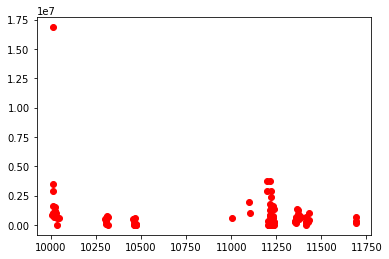

In [184]:

# visualize location

X_grid = np.arange(1900, 2020, 1)
X_grid = X_grid.reshape((len(X_grid), 1))
num_scatter = 100
plt.scatter([int(arr[0]) for arr in X_test[:num_scatter]], [float(num) for num in y_test[:num_scatter]], color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Check It (Random Forest Regression Model)w/100 trees')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.show()


### Predictive Method GUI
Use a deep forest model to predict how much a single-family house would cost depending on the location, month of sale, and unit specifications.

In [267]:
# UI
import ipywidgets as widgets

wide_layout=widgets.Layout(width='40%', height='30px')
med_layout=widgets.Layout(width='32%', height='30px')
label_layout={'description_width': 'initial'}
## Month slider
user_month = widgets.SelectionSlider(
    options=[('January', 1),
             ('February', 2),
             ('March', 3),
             ('April', 4),
             ("May", 5),
             ("June", 6),
             ("July", 7),
             ("August", 8),
             ("September", 9),
             ("October", 10),
             ("November", 11),
             ("December",12)],
    value=9,
    description='Month bought in 2016/2017:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style=label_layout,
    layout=wide_layout
)

display(user_month)

##
user_yearbuilt = widgets.IntSlider(
    value=1950,
    min=1899,
    max=2016,
    step=1,
    description='Year house was built:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=label_layout,
    layout=wide_layout
)

display(user_yearbuilt)

## Borough/zip code dropdown
borough_zipcode_array = []
for line in borough1_zipcodes:
    borough_zipcode_array.append("Manhattan - " + str(line))
for line in borough2_zipcodes:
    borough_zipcode_array.append("Bronx - " + str(line))
for line in borough3_zipcodes:
    borough_zipcode_array.append("Brooklyn - " + str(line))
for line in borough4_zipcodes:
    borough_zipcode_array.append("Queens - " + str(line))
for line in borough5_zipcodes:
    borough_zipcode_array.append("Staten Island - " + str(line))

user_borough = widgets.Dropdown(
    options=borough_zipcode_array,#[('Manhattan', 1), ('Bronx', 2), ('Brooklyn', 3), ('Queens', 4), ('Staten Island', 5)],

    description='Location:',
    style=label_layout,
    layout=med_layout
)
display(user_borough)

## size
user_land_sqrft= widgets.BoundedIntText(
    value=1975,
    min=0,
    max=10000,
    step=1,
    description='Land sq.ft.',
    disabled=False,
    style=label_layout,
    layout=med_layout
)
display(user_land_sqrft)
user_gross_sqrft = widgets.BoundedIntText(
    value=3855,
    min=0,
    max=10000,
    step=1,
    description='Gross sq.ft.',
    disabled=False,
    style=label_layout,
    layout=med_layout
)
display(user_gross_sqrft)
## Generate button
gen_button = widgets.Button(
    description='Generate report',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='' # (FontAwesome names without the `fa-` prefix)
)
gen_output = widgets.Output()

display(gen_button, gen_output)

def on_button_clicked(b):
    with gen_output:
        #predict new result
        sample = np.array([user_borough.value,
                           user_zipcode.value,
                           user_yearbuilt.value,
                           user_month.value,
                           user_land_sqrft.value,
                           user_gross_sqrft.value]).reshape(1, -1)
        y_pred = regressor.predict(sample)
        print("Projected residance price: $" + f"{int(y_pred):,d}")

gen_button.on_click(on_button_clicked)

SelectionSlider(continuous_update=False, description='Month bought in 2016/2017:', index=8, layout=Layout(heig…

IntSlider(value=1950, continuous_update=False, description='Year house was built:', layout=Layout(height='30px…

Dropdown(description='Location:', layout=Layout(height='30px', width='32%'), options=('Manhattan - 10011', 'Ma…

BoundedIntText(value=1975, description='Land sq.ft.', layout=Layout(height='30px', width='32%'), max=10000, st…

BoundedIntText(value=3855, description='Gross sq.ft.', layout=Layout(height='30px', width='32%'), max=10000, s…

Button(button_style='success', description='Generate report', style=ButtonStyle(), tooltip='Click me')

Output()

In [193]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print('new')

int_range.observe(on_value_change)

IntSlider(value=0)

Output()

In [131]:
import ipywidgets as widgets
a = widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

display(a)
print(a.value)


FloatSlider(value=7.5, continuous_update=False, description='Test:', max=10.0, readout_format='.1f')

7.5


In [132]:
import ipywidgets as widgets
user_date = widgets.DatePicker(
    description='Pick a month',
    disabled=False
)

display(user_date)

DatePicker(value=None, description='Pick a month')